In [2]:
# 1. Install dependencies (run once per runtime)
!pip -q install datasets transformers peft evaluate scikit-learn

import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
Device: cuda


In [3]:
# 2. Load GoEmotions and create 3-class sentiment labels (0=neg,1=neu,2=pos)
ds = load_dataset("go_emotions")  # default config
print(ds)

sentiment_mapping = {
    'admiration': 'positive',
    'amusement': 'positive',
    'anger': 'negative',
    'annoyance': 'negative',
    'approval': 'positive',
    'caring': 'positive',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'desire': 'positive',
    'disappointment': 'negative',
    'disapproval': 'negative',
    'disgust': 'negative',
    'embarrassment': 'negative',
    'excitement': 'positive',
    'fear': 'negative',
    'gratitude': 'positive',
    'grief': 'negative',
    'joy': 'positive',
    'love': 'positive',
    'nervousness': 'negative',
    'optimism': 'positive',
    'pride': 'positive',
    'realization': 'neutral',
    'relief': 'positive',
    'remorse': 'negative',
    'sadness': 'negative',
    'surprise': 'neutral',
    'neutral': 'neutral',
    }

sign = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
    }

label_names = ds["train"].features["labels"].feature.names

def avg_polarity_from_ids(ids):
    if not ids:
        return 0.0
    vals = [sign[sentiment_mapping[label_names[i]]] for i in ids]
    return float(np.mean(vals))

def to_3cls(ap, margin=0.5):
    if ap >=  margin:
        return 2  # positive
    if ap <= -margin:
        return 0  # negative
    return 1      # neutral

def add_targets(example):
    ap = avg_polarity_from_ids(example["labels"])
    example["avg_polarity"] = ap          # kept for analysis but NOT used for training
    example["label_cls3"]   = to_3cls(ap) # this is the CE target
    return example

ds = ds.map(add_targets)
print("Columns after add_targets:", ds["train"].column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Columns after add_targets: ['text', 'labels', 'id', 'avg_polarity', 'label_cls3']


In [4]:
# 3. Tokenize once
MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized = ds.map(tok, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
# 4. Keep only fields needed for 3-class classification
def prep_cls(split):
    keep = {"input_ids", "attention_mask", "token_type_ids", "label_cls3"}
    split = split.remove_columns([c for c in split.column_names if c not in keep])
    return split.rename_column("label_cls3", "labels")

train_ds = prep_cls(tokenized["train"])
val_ds   = prep_cls(tokenized["validation"])
test_ds  = prep_cls(tokenized["test"])

print("Train columns:", train_ds.column_names)
print("Example:", train_ds[0])


Train columns: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Example: {'labels': 1, 'input_ids': [101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000, 5660, 2870, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [6]:
# 5. Define LoRA-wrapped BERT (3-class single-label classification)
collator = DataCollatorWithPadding(tokenizer)

def make_lora_model():
    base = AutoModelForSequenceClassification.from_pretrained(
        MODEL,
        num_labels=3,
        problem_type="single_label_classification",
    )
    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"],  # Q+V is a good default
    )
    return get_peft_model(base, lora_cfg)

model = make_lora_model().to(device)
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 297219


In [7]:
# 6. Metrics for 3-class CE
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [8]:
# 7. Train with cross-entropy only
common_args = dict(
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=200,
    save_strategy="no",
    report_to="none",
    seed=42,
)

args_cls = TrainingArguments(
    output_dir="out_bert_lora_cls3_ce",
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    **common_args,
)

trainer_cls = Trainer(
    model=model,
    args=args_cls,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics_cls,
)

trainer_cls.train()
val_metrics  = trainer_cls.evaluate(val_ds)
test_metrics = trainer_cls.evaluate(test_ds)
print("Classification (CE) validation:", val_metrics)
print("Classification (CE) test:", test_metrics)


/tmp/ipython-input-3579273764.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_cls = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.633900,0.637141,0.725212,0.716212
2,0.601700,0.617461,0.733690,0.721926
3,0.573300,0.608714,0.737928,0.726392


Classification (CE) validation: {'eval_loss': 0.6087139248847961, 'eval_accuracy': 0.7379284924437891, 'eval_f1_macro': 0.7263916144840437, 'eval_runtime': 12.5684, 'eval_samples_per_second': 431.717, 'eval_steps_per_second': 6.763, 'epoch': 3.0}
Classification (CE) test: {'eval_loss': 0.5839459896087646, 'eval_accuracy': 0.7473742399115534, 'eval_f1_macro': 0.7396316524968557, 'eval_runtime': 12.4309, 'eval_samples_per_second': 436.574, 'eval_steps_per_second': 6.838, 'epoch': 3.0}


              precision    recall  f1-score   support

         neg     0.6773    0.7008    0.6889      1180
         neu     0.7391    0.6939    0.7158      2225
         pos     0.7959    0.8333    0.8142      2022

    accuracy                         0.7474      5427
   macro avg     0.7375    0.7427    0.7396      5427
weighted avg     0.7468    0.7474    0.7466      5427



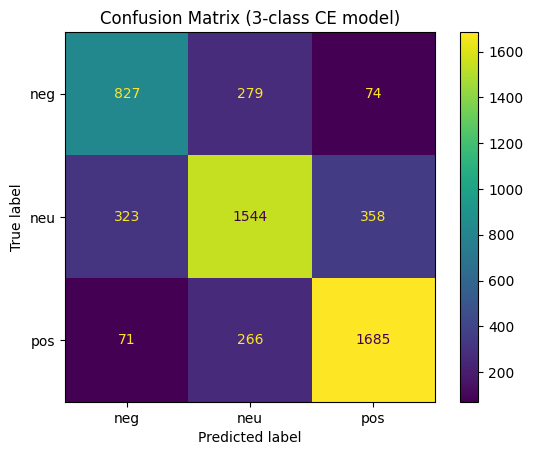

TypeError: Wrong key type: '5396' of type '<class 'numpy.int64'>'. Expected one of int, slice, range, str or Iterable.

In [16]:
# 8. Confusion matrix & classification report on test set
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

preds_out = trainer_cls.predict(test_ds)
logits = preds_out.predictions
y_pred = logits.argmax(axis=-1)
y_true = preds_out.label_ids

# text report
print(classification_report(
    y_true,
    y_pred,
    target_names=["neg", "neu", "pos"],  # or ["negative","neutral","positive"]
    digits=4
))

# confusion matrix (same style as your earlier code)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["neg", "neu", "pos"])
disp.plot(values_format="d")
plt.title("Confusion Matrix (3-class CE model)")
plt.show()


In [19]:
import random

val_texts = ds["validation"]["text"]

idxs = random.sample(range(len(y_true)), k=10)
for i in idxs:
    print(f"\n[{i}]")
    print("text:      ", val_texts[i][:300].replace("\n"," "))
    print("true:      ", round(y_true[i], 4))
    print("pred:      ", round(y_pred[i], 4), "  (err:", round(y_pred[i]-y_true[i], 4), ")")


[4837]
text:       I’m so glad someone linked it. You’re doing the important work. 🤣
true:       2
pred:       2   (err: 0 )

[3456]
text:       *sees title* hello there!
true:       1
pred:       0   (err: -1 )

[260]
text:       Just gotta stop overthinking. Try meditation. That helps control your thoughts better.
true:       0
pred:       0   (err: 0 )

[244]
text:       I’m sorry you’re dealing with this too. But hopefully it helps to know you’re not alone...?
true:       0
pred:       1   (err: 1 )

[767]
text:       > why have all of my responses been restating my opinion Because you're cruising on righteous indignation rather than empirical evidence. Facts don't care about your feelings.
true:       0
pred:       1   (err: 1 )

[1791]
text:       Was just wondering about the mobile thing. I only use mobile and I've never noticed anything odd. It's not something people would care about anyhow.
true:       0
pred:       1   (err: 1 )

[1905]
text:       Good to know! Very much ap